https://github.com/carlosbrown2/ultimate-challenge/blob/master/ultimate%20challenge.ipynb

https://github.com/mrytting/Ultimate-Challenge/blob/master/Ultimate%20Challenge.ipynb


https://github.com/vibaskaran/SpringBoard/blob/master/ultimate_challenge/Ultimate_Challenge_Solution.ipynb

https://github.com/rounakbanik/dsc_springboard/blob/master/challenges/ultimate/ultimate.ipynb

https://github.com/pjandir/Springboard-DSTrack/blob/master/Exercises/take_home_challenges_20.1/ultimate_challenge/solution.ipynb

# Ultimate Challenge
This is the solution to the Ultimate Challenge. The three parts are completed in order. The answers can be found within each part.

## Loading Data and Libraries

In [1]:
import json
from pandas.io.json import json_normalize
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
path1='/content/drive/MyDrive/ultimate_challenge/logins.json'
path2='/content/drive/MyDrive/ultimate_challenge/ultimate_data_challenge.json'

# load as Pandas dataframe
login_df = pd.read_json(path1)
login_df.head()
df=pd.read_json(path2)

In [3]:
#preview the first five records
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


## Data Wrangling
In this section, I will proceed to aggregate our login counts into 15 minute intervals and construct separate features to denote year, month, day and time.

In [4]:
login_df.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


So, we can see this data is just login times. Interestingly, there are duplicates. Presumably there are many users in this dataset. Also note, this data only comprises 3.5 months, starting on the first of January to about the middle of April. We can now visualize the data, in the prompted 15minute aggregation.

In [5]:
login_df['count'] = 1
login_df = login_df.set_index('login_time')

login_df.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [6]:
log_df = login_df.groupby(pd.Grouper(freq='15Min')).aggregate(np.sum) 
log_df['count'] = log_df['count'].fillna(0)
log_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


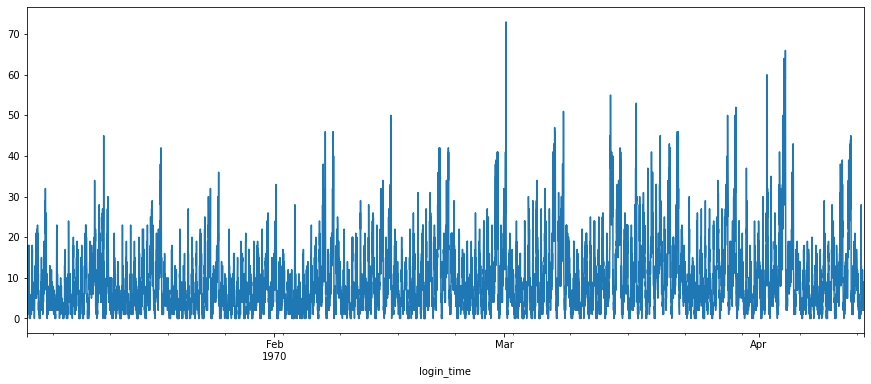

In [7]:

plt.figure(figsize=(15,6))
log_df['count'].plot()

In [8]:
# There is not much we can infer from this graph except for the fact that the login counts seem to be roughly periodic in nature. 
# It would be interesting to discover the periodicity of the above graph.

log_df['timestamp'] = pd.to_datetime(log_df.index)
log_df.head()

,count,timestamp
login_time,,
1970-01-01 20:00:00,2,1970-01-01 20:00:00
1970-01-01 20:15:00,6,1970-01-01 20:15:00
1970-01-01 20:30:00,9,1970-01-01 20:30:00
1970-01-01 20:45:00,7,1970-01-01 20:45:00
1970-01-01 21:00:00,1,1970-01-01 21:00:00


In [9]:
log_df['month'] = log_df['timestamp'].dt.month_name()
log_df['day'] = log_df['timestamp'].dt.day_name()
log_df['hour'] = log_df['timestamp'].dt.hour
log_df['time'] = log_df['timestamp'].dt.time
log_df.head()

,count,timestamp,month,day,hour,time
login_time,,,,,,
1970-01-01 20:00:00,2,1970-01-01 20:00:00,January,Thursday,20,20:00:00
1970-01-01 20:15:00,6,1970-01-01 20:15:00,January,Thursday,20,20:15:00
1970-01-01 20:30:00,9,1970-01-01 20:30:00,January,Thursday,20,20:30:00
1970-01-01 20:45:00,7,1970-01-01 20:45:00,January,Thursday,20,20:45:00
1970-01-01 21:00:00,1,1970-01-01 21:00:00,January,Thursday,21,21:00:00


# Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

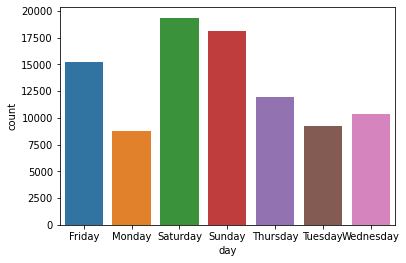

In [10]:
day_counts = log_df.groupby('day')['count'].sum()
sns.barplot(x=day_counts.index, y=day_counts)

**Observations:**
- Saturday is the most popular day for users followed by Sunday and Friday respectively.
- Monday shows the least activity.
- This strongly suggests that users are more active on the platform on the weekends than on the weekdays.

In [11]:
month_counts = log_df.groupby('month')['count'].sum()
month_counts

month
April       13507
February    24673
January     21239
March       33723
Name: count, dtype: int64

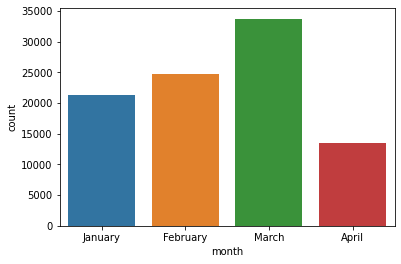

In [12]:
month_counts = log_df.groupby('month')['count'].sum()
sns.barplot(x=month_counts.index, y=month_counts, order=['January', 'February', 'March', 'April'])

**Observations**
Our login counts have been recorded from 1st January, 1970 to 13th April, 1970. We can see that the number of logins has progressively increased over the months (April had just 13 days of activity recorded). This indicates an increasing user base.

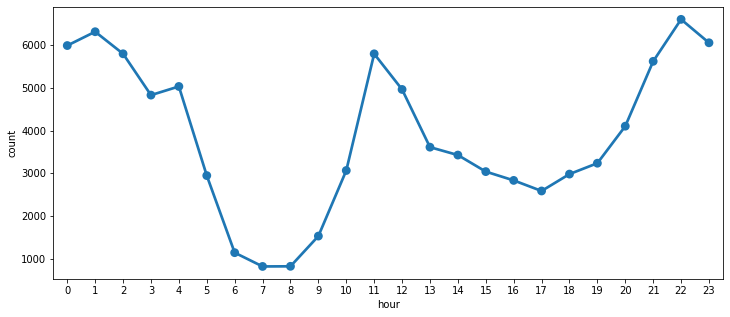

In [13]:
hour_counts = log_df.groupby('hour')['count'].sum()
plt.figure(figsize=(12,5))
sns.pointplot(x=hour_counts.index, y=hour_counts)

The graph above shows us the amount of activity recorded every hour of the day.

**Observations**
- The platform records maximum activity between 10 PM and 1 AM.
- There is also a sharp rise in user activity at around noon.
- The least activity is recorded during early morning between 6 AM and 8 AM.

**15 Minute Intervals**


Finally, let us have a look at the amount of activity recorded at every 15 minute interval.

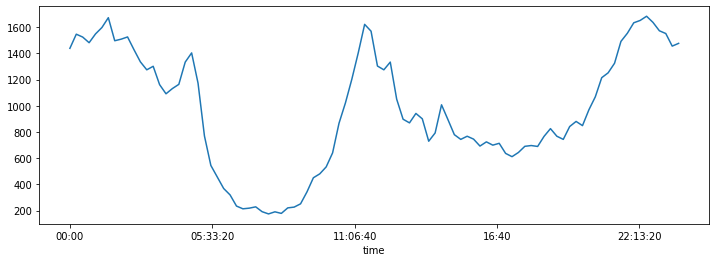

In [14]:
time_counts = log_df.groupby('time')['count'].sum()
time_counts.sort_values(ascending=False)
plt.figure(figsize=(12,4))
time_counts.plot()

The shape of this graph closely mirrors that of the graph obtained in the previous subsection. There is not too much additional insights to be gained from this.

# Part 2 Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs

**Success Metrics**

Note: I'm assuming the demand is equal in both the cities. That is, the demand of cabs in Gotham during the night is the same as the demand of cabs in Metropolis during the day.

We know that the demand in both the cities is complementary in the weekdays; i.e the demand for both cities can be met by the same driver partners as they are at different times. Therefore, if this experiment was indeed sucessful, it would indicate that the drivers, irrespective of which city they belong to, are spending equal amounts of time in Gotham and Metropolis during the weekdays; Metropolis during the day and Gotham during the night.

The success metric I propose is the ratio of passengers taken from Gotham and Metropolis on weekdays. After the introduction of this experiment, if the ratio has regressed towards 1:1, it would mean that the experiment was successful.

**Experiment**

1. These are the steps I will implement as part of an experiment to deduce if the policy changes have affected the behavior of the drivers.

2. Track the activity of every driver in each city. If the number of Gotham passengers for a particular driver is more, label him/her as a Gotham Driver. Else label as Metropolis Driver.
3. Calculate the proportion of passengers from two cities and divide them into two sample groups: before the experiment and after the experiment.
Perform hypothesis testing using the Difference of Proportions test on the two samples. Calculate the Z-Statisitc and the p-value and compare it with an arbritrary significance level, $\alpha$.
If the Null Hypothesis holds, it implies that the experiment has been a failure. If the Alternate hypothesis holds, it implies that it has been a success.
I will perform the experiment described above and test if the Null Hypothesis can be rejected for both groups. If this is true, then I will suggest that Ultimate Inc continue implementing this policy change. If it cannot be rejected, then I will suggest that they stop and look for other potent options.

## Predictive Modelling

In [15]:
try:
    df2 = pd.read_json('path2')
except:
    print("Unable to load JSON into Pandas DataFrame")

Unable to load JSON into Pandas DataFrame


It seems like our data is not in a format that can be directly loaded into a Pandas Dataframe. Therefore, we will have to use Python's File I/O functions to load the data manually.

In [16]:
data = open(path2, 'r').readline()
data = json.loads(data)
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [18]:
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

 It seems that iPhones are significantly more popular than Android phones. Therefore, we will impute the missing values with iPhone.

In [19]:
df['phone'] = df['phone'].fillna('iPhone')
df['avg_rating_by_driver'].describe()

count    49799.000000
mean         4.778158
std          0.446652
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

There is in fact a large amount of outlier because of the heavy one-sidedness in the distributions. We can probably remove some of the rows associated with some of these extreme values. However, we must keep in mind that because of the heavy skew many outliers should be expected. In that vein, we will remove outliers outside a standard deviation of 4 from the mean for each column. First, we can do a quick check to see how many outliers would be removed with this process.

The median rating is 5. We will impute the very few missing values we have with 5.

In [20]:
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())

df['avg_rating_of_driver'].describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


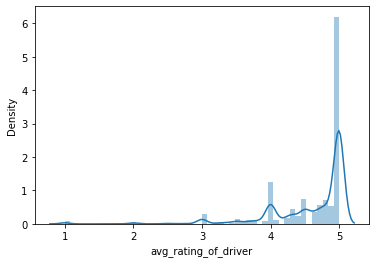

In [21]:
sns.distplot(df[df['avg_rating_of_driver'].notnull()]['avg_rating_of_driver'])

Passengers are slightly less lenient with their ratings than drivers. I will just impute the missing values with the mean.

In [22]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())

df['signup_date'] = df['signup_date'].apply(lambda x: pd.Timestamp(x, tz=None))
df['last_trip_date'] = df['last_trip_date'].apply(lambda x: pd.Timestamp(x, tz=None))

df['last_trip_date'].sort_values(ascending=False).head(10)

45357   2014-07-01
22735   2014-07-01
14473   2014-07-01
38651   2014-07-01
45126   2014-07-01
14419   2014-07-01
38661   2014-07-01
45143   2014-07-01
45154   2014-07-01
45155   2014-07-01
Name: last_trip_date, dtype: datetime64[ns]

We see that this data was taken on 1st July, 2014. Therefore, a user is considered retained if s/he took a trip after June 1st, 2014.

In [23]:
df['retained'] = df['last_trip_date'].apply(lambda x: 1 if x >= pd.Timestamp('2014-06-01', tz=None) else 0)

df['retained'].value_counts()

0    31196
1    18804
Name: retained, dtype: int64

We see that Ultimate Inc. has been able to retain 18,804 or 37.6% of its Userbase. This retention rate is not that high.

Since our users have all signed up in January 2014, we can drop it as it doesn't really indicate much.

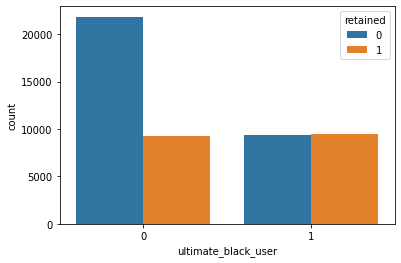

In [24]:
df = df.drop('signup_date', axis=1)

df = df.drop('last_trip_date', axis=1)

df['ultimate_black_user'] = df['ultimate_black_user'].apply(lambda x: 1 if x else 0)

sns.countplot(x='ultimate_black_user', data=df, hue='retained')

We can now also make histograms of the numeric variables to better understand their distributions. There is heavy skew in most of the above plots. So let's also make box plots to see what kinds of outliers might exist in this dataset.

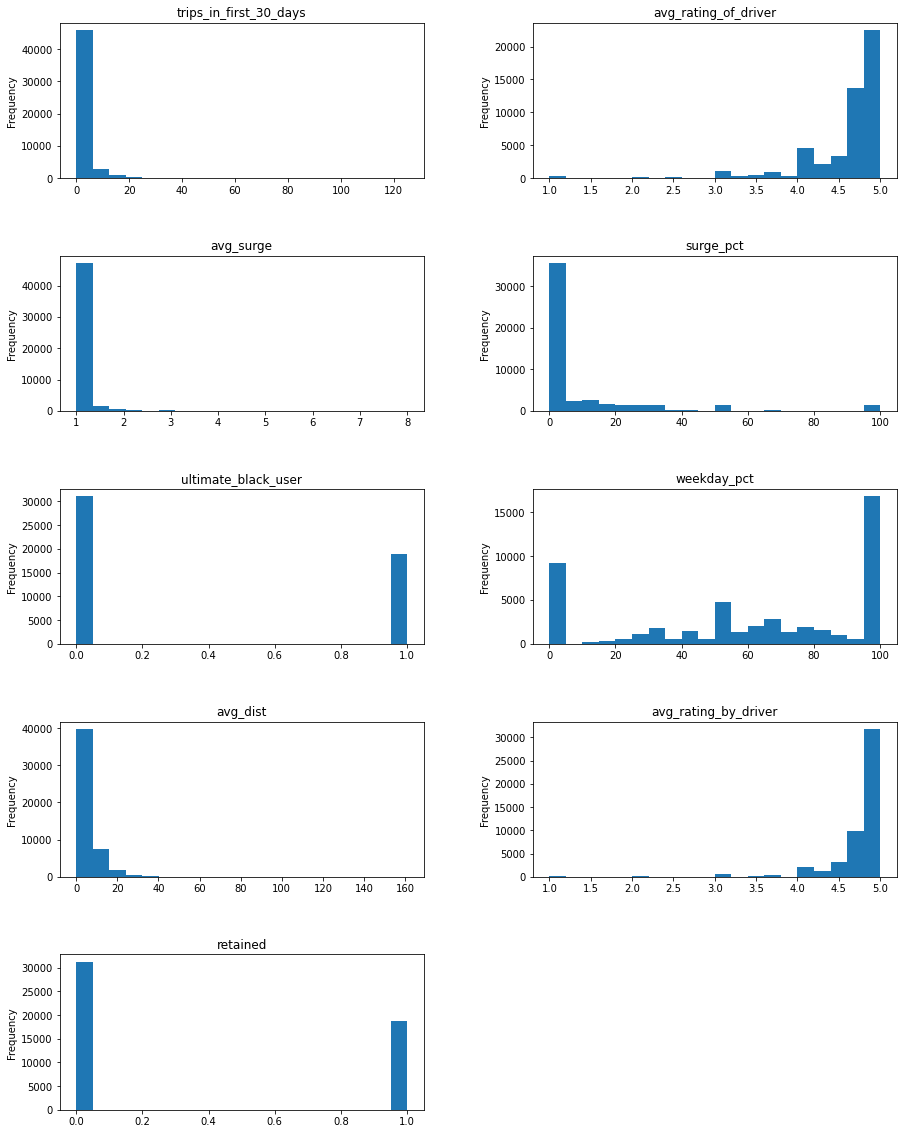

In [25]:
#Make subplotted figure
fig, axes = plt.subplots(4, 2, figsize=(15,20))

#Cycle through all relevant columns
i = 1
for col in df.select_dtypes(include=[np.float64, np.int64, np.bool]).columns:
    plt.subplot(5, 2, i)
    df[col].plot.hist(title=col, logy=False, bins=20)
    i += 1

#Show
fig.subplots_adjust(hspace=0.5, wspace=0.3)    
plt.show()

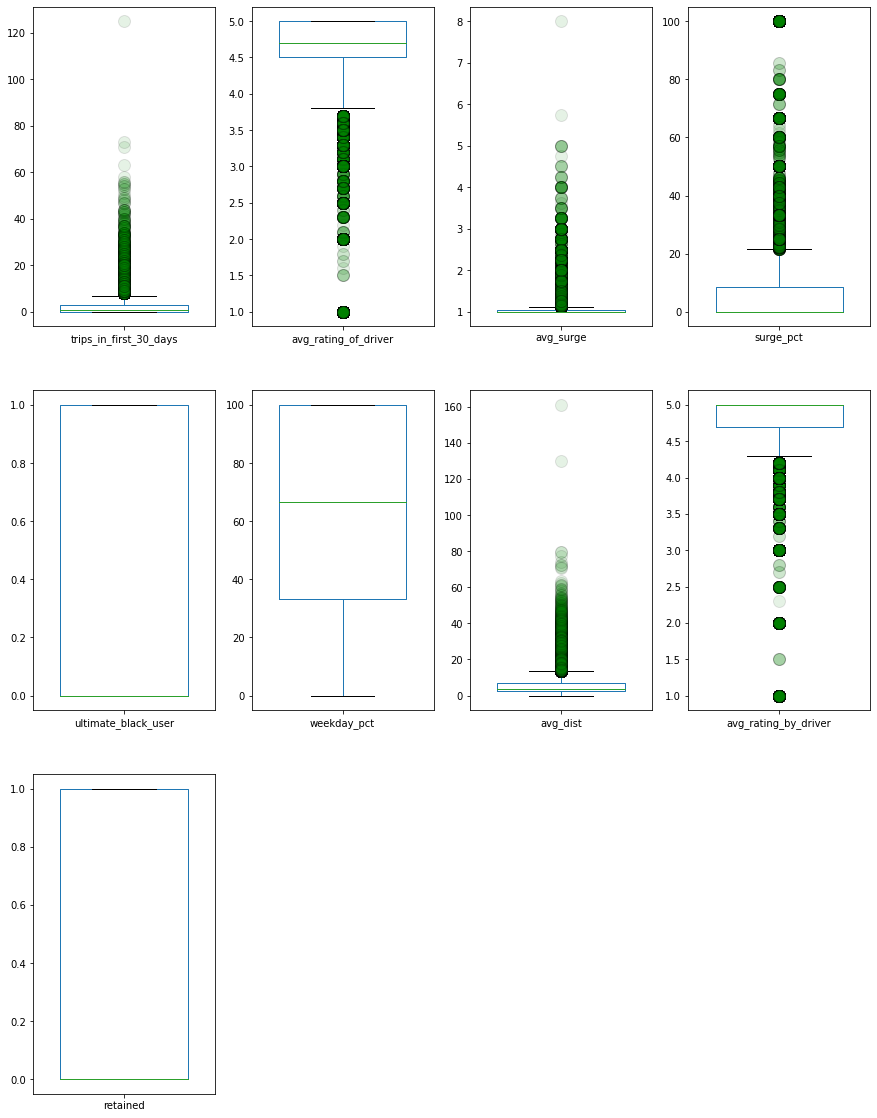

In [26]:
#Make subplotted figure
fig, axes = plt.subplots(2, 4, figsize=(15,20))

#Cycle through all relevant columns
i = 1
for col in df.select_dtypes(include=[np.float64, np.int64, np.bool]).columns:
    plt.subplot(3,4, i)
    df[col].plot.box(widths=0.7, flierprops=dict(markerfacecolor='g', markersize=12, alpha=0.1), vert=True)
    i += 1

#Show
plt.show()

Ultimate Black Users are much more likely to be retained as compared to the rest of the population.

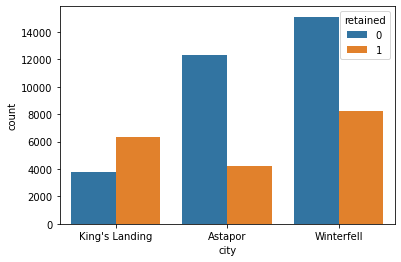

In [27]:
sns.countplot(x='city', data=df, hue='retained')

King's Landing seems to be especially successful in retaining users whereas Astapor is the least successful.

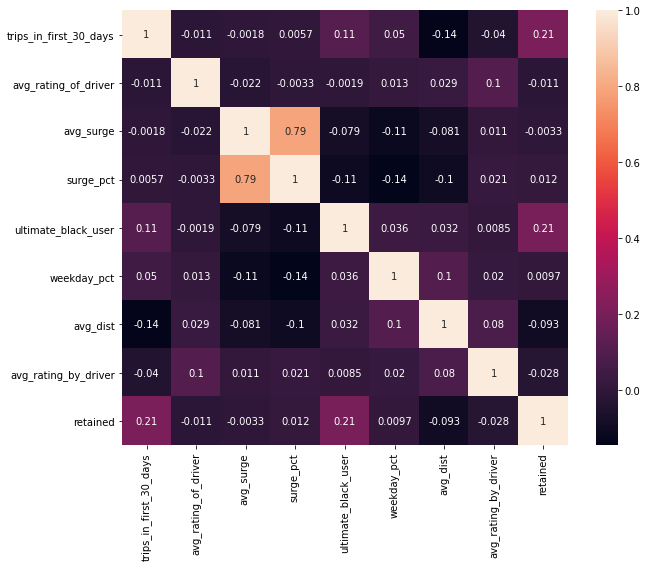

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
df = pd.get_dummies(df, prefix='is')

X, y = df.drop(['retained', 'avg_surge'], axis=1), df['retained']

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.85, test_size=0.15, stratify=y)

classifier = GradientBoostingClassifier(verbose=True, n_estimators=200)
classifier.fit(train_X, train_y)
classifier.score(test_X, test_y)

      Iter       Train Loss   Remaining Time 
         1           1.2795           12.95s
         2           1.2432           12.18s
         3           1.2119           11.81s
         4           1.1842           11.91s
         5           1.1621           11.73s
         6           1.1418           11.32s
         7           1.1241           10.81s
         8           1.1085           10.83s
         9           1.0895           10.85s
        10           1.0772           10.80s
        20           0.9943           10.33s
        30           0.9581            9.79s
        40           0.9394            9.25s
        50           0.9287            8.67s
        60           0.9216            8.12s
        70           0.9168            7.52s
        80           0.9127            6.94s
        90           0.9100            6.35s
       100           0.9068            5.78s
       200           0.8873            0.00s


0.7869333333333334

Our classifier reports an accuracy of 79.5%. The model that we used was the Gradient Boosting Classifier.

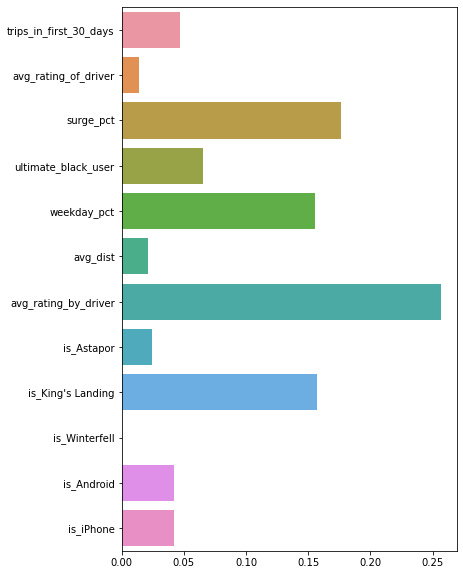

In [30]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=classifier.feature_importances_)

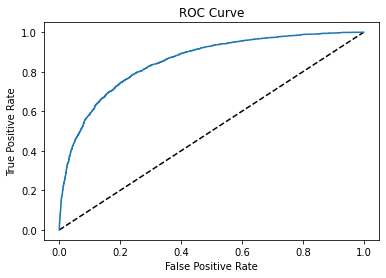

In [31]:

from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = classifier.predict_proba(test_X)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [32]:
# make predictions for test data
y_pred = classifier.predict(test_X)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.69%


**Recommendations**

From the feature importances, we can see that the two most important predictors are the avg_rating_by_driver and surge_pct. This makes sense, because a high surge_pct means lots of using the Ultimate service. Coupled with an emphasis on the rating by the driver, and the high volume users tend to stay on the service. This is confirmed by the weekday_pct being the fourth highest predictor. It means users who also use Ultimate during the weekend, tend to use it all the time, thereby increasing their chances of being retained.

Ultimate can try to take advantage of this info in a few ways. Users from Winterfell tend to not be retained, at all, so perhaps do some marketing/PR for those people. There might also be a message to drivers to treat their customers better so their driver rating goes up. That might help with users wanting to use Ultimate more often, as they view drivers more positively.

